In [1]:
from toolz import merge, valmap

import torch

import tmol.utility.cpp_extension as cpp_extension
import tmol.tests.utility.test_cpp_extension

torch.set_num_threads(1)

In [2]:
from tmol.tests.benchmark import make_fixture, make_subfixture, subfixture, stat_frame

In [3]:
def with_sync(f):
    def ex(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        finally:
            torch.cuda.synchronize()
    return ex

def d_naive(v):
    return (v * v).sum(dim=-1).sqrt()

def d_norm(v):
    return v.norm(dim=-1)

In [4]:
vector_magnitude = tmol.tests.utility.test_cpp_extension.vector_magnitude()

Using /tmp/torch_extensions as PyTorch extensions root...
Emitting ninja build file /tmp/torch_extensions/vector_magnitude/build.ninja...
Building extension module vector_magnitude...
Loading extension module vector_magnitude...


In [7]:
import itertools

In [8]:
methods = valmap(with_sync, {
    "aten": vector_magnitude.aten,
    "accessor": vector_magnitude.accessor,
    "eigen": vector_magnitude.eigen,
})

sizes = [10**e for e in range(3,7)]
benchmarks = []

fix = make_fixture("v_norm", add_stats=benchmarks.append, max_time=.5)

results = {}

for s in sizes:
    tv = torch.rand((s, 3))
    
    results[s] = merge(
        {
            n : make_subfixture(fix, f".{n}", elements=s, device="cpu", method=n)(lambda : m(tv))
            for n, m in methods.items()
        }
    )

for s, vs in results.items():
    for t1, t2 in itertools.product(vs, vs):
        torch.testing.assert_allclose(vs[t1], vs[t2])
        

In [9]:
import seaborn
from matplotlib import pyplot

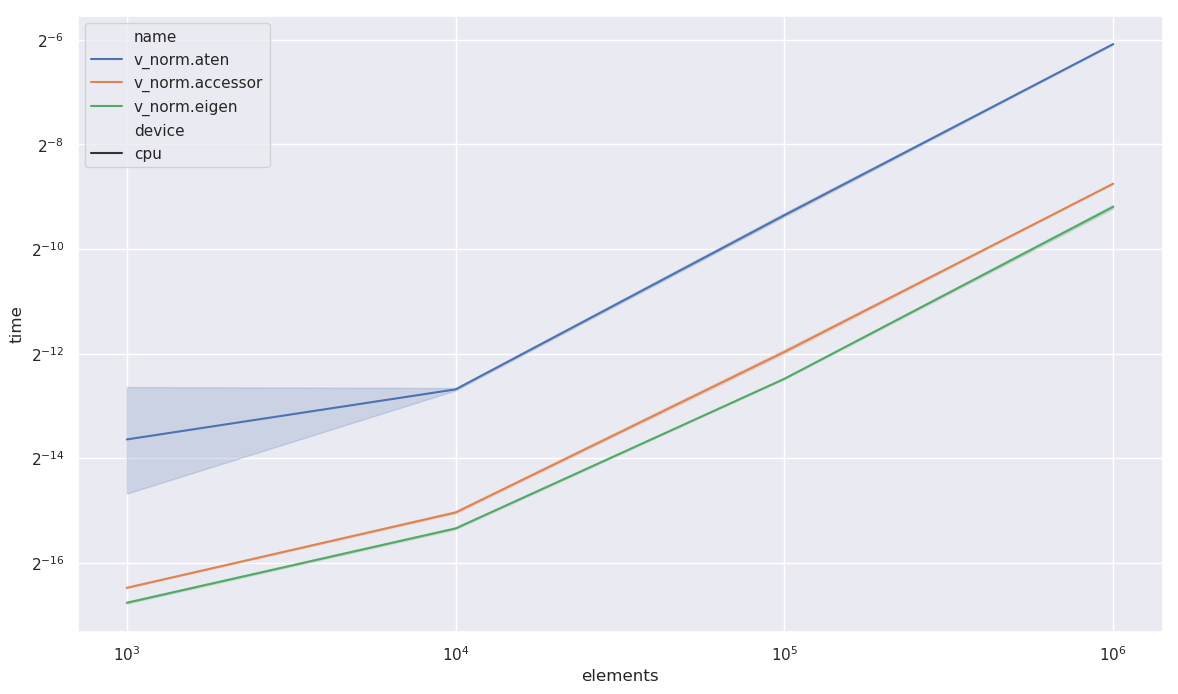

In [10]:
dat = stat_frame(benchmarks)
pyplot.yscale("log", basey=2)
pyplot.xscale("log", basex=10)
seaborn.lineplot("elements", "time", data=dat, hue="name", style="device")